In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.cluster import KMeans


In [2]:
data = pd.read_csv('drugsComTrain_raw.csv')

In [3]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
data.shape

(161297, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [6]:
data.duplicated().sum()

0

In [7]:
data.isnull().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [8]:
data = data.dropna()

In [9]:
data.isnull().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [10]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Clean the reviews
stop_words = set(stopwords.words('english'))

def clean_review(text):
    text = re.sub(r'\W', ' ', text)  
    tokens = word_tokenize(text.lower()) 
    filtered_tokens = [word for word in tokens if word not in stop_words]  
    return ' '.join(filtered_tokens)

data['cleaned_condition'] = data['condition'].apply(clean_review)
data['cleaned_review'] = data['review'].apply(clean_review)
data['cleaned_drugName'] = data['drugName'].apply(clean_review)




In [11]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_condition,cleaned_review,cleaned_drugName
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,left ventricular dysfunction,side effect take combination bystolic 5 mg fis...,valsartan
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,adhd,son halfway fourth week intuniv became concern...,guanfacine
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,birth control,used take another oral contraceptive 21 pill c...,lybrel
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,birth control,first time using form birth control 039 glad w...,ortho evra
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,opiate dependence,suboxone completely turned life around feel he...,buprenorphine naloxone


In [12]:
# Initialize TF-IDF Vectorizers
tfidf_review = TfidfVectorizer()
tfidf_condition = TfidfVectorizer()
tfidf_drugName = TfidfVectorizer()


# Transform text data to TF-IDF matrices
tfidf_review_matrix = tfidf_review.fit_transform(data['cleaned_review'])
tfidf_condition_matrix = tfidf_condition.fit_transform(data['cleaned_condition'])
tfidf_drugName_matrix = tfidf_drugName.fit_transform(data['cleaned_drugName'])



In [13]:
combined_text = hstack([tfidf_condition_matrix, tfidf_drugName_matrix])


In [14]:
numerical_features = data[['rating', 'usefulCount']]


In [15]:
combined_feature = hstack([combined_text, numerical_features])


In [16]:
wcss = []
k_range = range(1, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_feature)
    wcss.append(kmeans.inertia_)

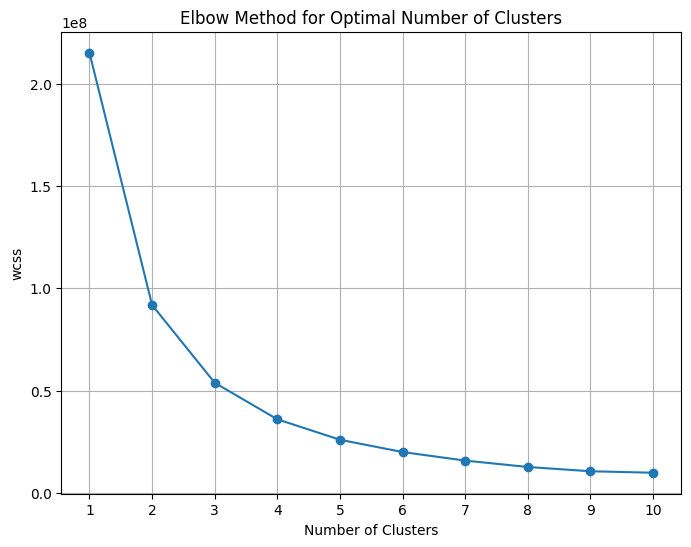

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [18]:
from kneed import KneeLocator

kl = KneeLocator(k_range,wcss,curve='convex',direction='decreasing')
kl.elbow

3

In [19]:
num_clusters = 3  

kmeans = KMeans(n_clusters=num_clusters, random_state=42)

kmeans.fit(combined_feature)

data['cluster'] = kmeans.labels_


In [20]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

data['sentiment'] = data['cleaned_review'].apply(get_sentiment)




In [21]:
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_condition,cleaned_review,cleaned_drugName,cluster,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,left ventricular dysfunction,side effect take combination bystolic 5 mg fis...,valsartan,1,0.000000
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,adhd,son halfway fourth week intuniv became concern...,guanfacine,0,0.148611
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,birth control,used take another oral contraceptive 21 pill c...,lybrel,1,0.119805
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,birth control,first time using form birth control 039 glad w...,ortho evra,1,0.262500
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,opiate dependence,suboxone completely turned life around feel he...,buprenorphine naloxone,2,0.194444


In [22]:
from sklearn.metrics.pairwise import cosine_similarity


In [23]:
filtered_df = data[data['cleaned_condition'] == 'adhd']
filtered_df.head()

# This line filters the data DataFrame to create filtered_df, which contains only the rows where the cleaned_condition matches the cleaned input condition.

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_condition,cleaned_review,cleaned_drugName,cluster,sentiment
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,adhd,son halfway fourth week intuniv became concern...,guanfacine,0,0.148611
27,78563,Daytrana,ADHD,"""Hi all, My son who is 12 was diagnosed when h...",10,12-Jan-17,11,adhd,hi son 12 diagnosed 2nd grade tried everything...,daytrana,1,0.089744
51,135645,Intuniv,ADHD,"""Intuniv did not work for my son; he was bounc...",1,21-Jul-11,23,adhd,intuniv work son bouncing walls taking major i...,intuniv,1,0.031250
116,61002,Focalin,ADHD,"""My 9 year old son has been on various medicin...",9,31-Jan-10,48,adhd,9 year old son various medicines adhd since 6 ...,focalin,2,-0.088889
211,37533,Vyvanse,ADHD,"""Today was my first day taking Vyvanse and wow...",9,31-Aug-11,11,adhd,today first day taking vyvanse wow usually sad...,vyvanse,1,0.067535


In [24]:
# if not filtered_df.empty:
# This line checks if filtered_df is not empty. If it is not empty, it means there are records for the specified condition.

In [25]:
similarity_matrix = cosine_similarity(filtered_df[['sentiment']])
#  If there are three drugs in filtered_df with sentiment scores [0.2, 0.5, 0.8], the cosine similarity will measure how closely these sentiment scores relate to each other.

In [26]:
similarity_df = pd.DataFrame(similarity_matrix, index=filtered_df.index, columns=filtered_df.index)
# This line creates a new DataFrame, similarity_df, that stores the cosine similarity values. The index and columns of this DataFrame correspond to the indices of the filtered_df DataFrame.

In [27]:
similarity_df.head()

,1,27,51,116,211,250,268,313,376,382,...,160604,160743,160809,160839,160848,160977,160998,161084,161111,161213
1,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,...,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,0.0
27,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,...,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,0.0
51,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,...,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,0.0
116,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,0.0
211,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,...,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,0.0


In [28]:
#     Drug A	Drug B	Drug C
# A	1.0	0.8	0.5
# B	0.8	1.0	0.6
# C	0.5	0.6	1.0

In [29]:
# When you apply sum(axis=1):
# For Drug A: 1.0 + 0.8 + 0.5 = 2.3
# For Drug B: 0.8 + 1.0 + 0.6 = 2.4
# For Drug C: 0.5 + 0.6 + 1.0 = 2.1

In [30]:

# Drug	Similarity Sum
# Drug A	2.3
# Drug B	2.4
# Drug C	2.1

In [31]:
# Sorting this Series in descending order would give:
# Drug	Similarity Sum
# Drug B	2.4
# Drug A	2.3
# Drug C	2.1

In [32]:
recommended_indices = similarity_df.sum(axis=1).sort_values(ascending=False).index
top_recommendations = filtered_df.loc[recommended_indices].head(5)[['drugName', 'sentiment']]


In [33]:
def recommend_drugs(condition):
    cleaned_condition = clean_review(condition).strip()   
    filtered_df = data[data['cleaned_condition'] == cleaned_condition]

    if not filtered_df.empty:
        similarity_matrix = cosine_similarity(filtered_df[['sentiment']])
        similarity_df = pd.DataFrame(similarity_matrix, index=filtered_df.index, columns=filtered_df.index)

        recommended_indices = similarity_df.sum(axis=1).sort_values(ascending=False).index
        top_recommendations = filtered_df.loc[recommended_indices].drop_duplicates(subset=['drugName']).head(5)[['drugName', 'sentiment']]
        
        print("Recommended Drugs:")
        print(top_recommendations)
    else:
        print("No drugs found for the specified condition.")


In [34]:
condition_input = input("Enter condition: ")
print(condition_input)
recommend_drugs(condition_input)

Left Ventricular Dysfunction
Recommended Drugs:
          drugName  sentiment
157542  Benazepril   0.014861
52494   Carvedilol   0.187500
104363       Coreg   0.187500
13130   Metoprolol   0.247222
30491    Enalapril   0.173810


In [36]:
import nltk

In [37]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [39]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
data['condition']

0         Left Ventricular Dysfunction
1                                 ADHD
2                        Birth Control
3                        Birth Control
4                    Opiate Dependence
                      ...             
161292              Alcohol Dependence
161293                 Nausea/Vomiting
161294            Rheumatoid Arthritis
161295             Underactive Thyroid
161296           Constipation, Chronic
Name: condition, Length: 160398, dtype: object

In [58]:
wordnet.synsets('stultification')

[Synset('stultification.n.01'), Synset('stultification.n.02')]

In [47]:
wordnet.synsets('Constipation')

[Synset('constipation.n.01'), Synset('stultification.n.02')]

In [42]:
wordnet.synsets('ADHD')

[Synset('attention_deficit_disorder.n.01')]

wordnet

In [59]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms


In [60]:
def recommend_drugs(condition):
    cleaned_condition = clean_review(condition).strip()
    words = cleaned_condition.split()

    all_synonyms = set()
    for word in words:
        synonyms = get_synonyms(word)
        all_synonyms.update(synonyms)

    all_synonyms.update(words)

    cleaned_synonyms = set([clean_review(w) for w in all_synonyms])

    filtered_df = data[data['cleaned_condition'].isin(cleaned_synonyms)]
    # print(filtered_df.head())
    if not filtered_df.empty:
        similarity_matrix = cosine_similarity(filtered_df[['sentiment']])
        similarity_df = pd.DataFrame(similarity_matrix, index=filtered_df.index, columns=filtered_df.index)

        recommended_indices = similarity_df.sum(axis=1).sort_values(ascending=False).index
        top_recommendations = filtered_df.loc[recommended_indices].drop_duplicates(subset=['drugName']).head(5)[['drugName', 'sentiment']]

        print("Recommended Drugs:")
        print(top_recommendations)
    else:
        print("No drugs found for the specified condition or its synonyms.")


In [61]:
condition_input = input("Enter condition: ")
print(condition_input)
recommend_drugs(condition_input)


attention_deficit_disorder.n.01
Recommended Drugs:
                  drugName  sentiment
1               Guanfacine   0.148611
102422             Vyvanse   0.271548
100911  Dexmethylphenidate   0.483333
100956         Metadate CD   0.279167
101248             Intuniv   0.157837


In [80]:
import gensim


combine : wordnet and word2vec 

In [96]:
from gensim.models import Word2Vec


In [117]:
def get_wordnet_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower())
    return list(synonyms)

sentences = data['cleaned_condition'].apply(lambda x: x.split()).tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)

def get_word2vec_similar_words(word, model):
    try:
        similar_words = model.wv.most_similar(word)
        return [w[0] for w in similar_words]
    except KeyError:
        return []

def get_related_conditions(condition, model):
    synonyms = get_wordnet_synonyms(condition)
    similar_words = get_word2vec_similar_words(condition, model)
    return set(synonyms + similar_words)



In [118]:
# Recommendation 
def recommend_drugs(condition, model):
    cleaned_condition = clean_review(condition).strip()

    filtered_df = data[data['cleaned_condition'] == cleaned_condition]
    
    if filtered_df.empty:
        related_conditions = get_related_conditions(cleaned_condition, model)
        filtered_df = data[data['cleaned_condition'].isin(related_conditions)]
    
    if not filtered_df.empty:
        similarity_matrix = cosine_similarity(filtered_df[['sentiment']])
        similarity_df = pd.DataFrame(similarity_matrix, index=filtered_df.index, columns=filtered_df.index)

        recommended_indices = similarity_df.sum(axis=1).sort_values(ascending=False).index
        top_recommendations = filtered_df.loc[recommended_indices].drop_duplicates(subset=['drugName']).head(5)[['drugName', 'sentiment']]

        print("Recommended Drugs:")
        print(top_recommendations)
    else:
        print(f"No drugs found for the specified condition: {condition}")

In [119]:
condition_input = input("Enter condition: ")
print(condition_input)
recommend_drugs(condition_input, word2vec_model)

ADD
Recommended Drugs:
                  drugName  sentiment
1               Guanfacine   0.148611
102422             Vyvanse   0.271548
100911  Dexmethylphenidate   0.483333
100956         Metadate CD   0.279167
101248             Intuniv   0.157837
